# Underwater Image Restoration By Blue-Green Channels Dehazing and Red Channel Correction

## 1. The Challenge and Proposed Solution
Capturing clear underwater images is challenging due to various reasons namely,  <br>
  - Physical properties of underwater environment <br>
  - Effects of absorption and scattering <br>
  - Varying attenuation of light in different wavelengths <br>
    
<figure>
<center> <img src ="lightinwater.jpg" style="width:500px;height=500px"/></center>
<figcaption align = "center"><b>Fig.1 -This figure plots the differeing light intensities in water [4]</figcaption>
</figure> 
                                  
An underwater image can be decomposed into the superposition of a *direct*, *forward-scattering* and a *back-scattering* component. The forward scattering causes blurring of the image while the back-scattering masks the details of the senarios.  
<br>
With the help of Fig.1, we make the following obsevations: <br>
 - Red light is more easily absorbed than blue or green light
 - The shorter wavelengths of green and blue light scatter more than the long wavelength of red light
<br>
    
In [4], the following method is proposed for de-hazing of underwater images - using a modified version the Dark Channel Prior method to first de-haze the blue and green channels followed by the Red channel correction using the *Gray World Assumption theory*.

### 1.1. Flowchart 
<figure>
<center> <img src ="flowchart.jpg" style="width:500px;height=500px"/></center>
<figcaption align = "center"><b>Fig.2 -This figures depticts the flowchart for step-by-step implementation of the proposed method [4]</figcaption>
</figure> 
           
 

In [1]:
from IPython.display import HTML
from IPython.display import display

tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

In [2]:
import os
import datetime
import numpy as np
import cv2
import natsort
import matplotlib.pyplot as plt
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path
    
    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
            
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path
    
    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)
        
        print ("importing Jupyter notebook from %s" % path)
                                       
        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)

        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod
        
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__
        
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}
    
    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return
        
        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)
        
        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

sys.meta_path.append(NotebookFinder())

# Importing the required libraries and supporting functions
from extras.DetermineDepth import determineDepth
from extras.TransmissionEstimation import getTransmission
from extras.getAdaptiveSceneRadiance import AdaptiveSceneRadiance
from extras.getAtomsphericLight import getAtomsphericLight
from extras.sceneRadianceGb import sceneRadianceGB
from extras.sceneRadianceR import sceneradiance
from extras.GuidedFilter import GuidedFilter
from extras.guidedfilter_he import guided_filter_he


importing Jupyter notebook from C:\Users\Giridhar\Downloads\UnderwaterDeHaze_Lalitha\extras\DetermineDepth.ipynb
importing Jupyter notebook from C:\Users\Giridhar\Downloads\UnderwaterDeHaze_Lalitha\extras\TransmissionEstimation.ipynb
importing Jupyter notebook from C:\Users\Giridhar\Downloads\UnderwaterDeHaze_Lalitha\extras\getAdaptiveSceneRadiance.ipynb
importing Jupyter notebook from C:\Users\Giridhar\Downloads\UnderwaterDeHaze_Lalitha\extras\getAtomsphericLight.ipynb
importing Jupyter notebook from C:\Users\Giridhar\Downloads\UnderwaterDeHaze_Lalitha\extras\sceneRadianceGb.ipynb
importing Jupyter notebook from C:\Users\Giridhar\Downloads\UnderwaterDeHaze_Lalitha\extras\sceneRadianceR.ipynb
importing Jupyter notebook from C:\Users\Giridhar\Downloads\UnderwaterDeHaze_Lalitha\extras\GuidedFilter.ipynb
importing Jupyter notebook from C:\Users\Giridhar\Downloads\UnderwaterDeHaze_Lalitha\extras\guidedfilter_he.ipynb


In [3]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

def  refinedtransmission(transmission, img):
    # This function refines the transmission by using a guided filter to remove the halo effects
    gimfiltR = 50  # The size of the radius when guiding the filter
    eps = 10 ** -3  #The value of epsilon during bootstrap filtering

    guided_filter = GuidedFilter(img, gimfiltR, eps)
    transmission[:,:,0] = guided_filter.filter(transmission[:,:,0])
    transmission[:,:,1] = guided_filter.filter(transmission[:,:,1])
    transmission = np.clip(transmission, 0.1, 0.9)


    return transmission

In [6]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

def adapexpMap(img, sceneRadiance, Lambda, blockSize):
    # Applied as the final step of the image correction process where the regions that are either too bright or too dark are
    # adjusted accordingly to provide a balanced scene
    minValue = 10 ** -2
    img = np.uint8(img)
    sceneRadiance = np.uint8(sceneRadiance)

    yj_cr_cb = cv2.cvtColor(sceneRadiance, cv2.COLOR_BGR2YCrCb)
    yi_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    normyj_cr_cb = (yj_cr_cb - yj_cr_cb.min()) / (yj_cr_cb.max() - yj_cr_cb.min())
    normyi_cr_cb = (yi_cr_cb - yi_cr_cb.min()) / (yi_cr_cb.max() - yi_cr_cb.min())
    Yi = normyi_cr_cb[:, :, 0]
    Yj = normyj_cr_cb[:, :, 0]
    Yi = np.clip(Yi, minValue,1)
    Yj = np.clip(Yj, minValue,1)

    S = (Yj * Yi + 0.3 * Yi ** 2) / (Yj ** 2 + 0.3 * Yi ** 2)

    filR = 50  # The size of the radius when guiding the filter
    eps = 10 ** -3  # The value of epsilon during bootstrap filtering

    guided_filter = GuidedFilter(yi_cr_cb, filR, eps)

    refS = guided_filter.filter(S)

    S_three = np.zeros(img.shape)
    S_three[:, :, 0] = S_three[:, :, 1] = S_three[:, :, 2] = refS

    return S_three

## 2. Blue-Green Channels Dehazing 

Now, the attenuation of the blue and green channels result from scattering which is similar to the type of attenuation seen in tradionally terrestrial images. Based on this intuition, we can then describe the underwater imaging model described as  <br><br>
$ \begin{align}
I^{c}(x) = J^{c}(x)t(x) + B^{c}(1-t(x)), c \in \{g,b\}
\end{align} $ <br><br>
Here, <br>
    $I(x)$ : Observed image <br>
    $J(x)$ : Restored image <br>
    $B$ : Background light <br>
    $t(x) \in [0,1]$ is the medium transmission map based on camera parameters
<br>
<br>
The Background light *B* can be estimated from the knowledge that the Red channel attuates much faster than the green and blue channels underwater. First, the largest difference *D(x)* is computed by finding the difference between the maximum intensity of the red channel and the maximum intensity of the green and blue channels. <br><br>
$ \begin{align}
D(x) = \max_{ x \in \Omega,c \in r } I^{c}(x) - \max_{ x \in \Omega,c \in \{g,b\} } I^{c}(x)
\end{align} $ <br><br>

Here, $\Omega$ corresponds to a local patch in the image. From this, *B* is estimated as:
<br>
<br>
$ \begin{align}
B^{c} = avg(I^{c}(arg \min_{x} D(x))), c \in \{g,b\}
\end{align} $ <br><br>


### 2.1. Transmission Map for Blue and Green Channels
Based on the Rayleigh scattering theory the following assumptions are valid: 
 - Blue and Green channels have equal attenuation underwater
 - Transmission map for a given patch is same for both channels 
 
<br>
To find the transmission map we minimise the imaging model equation over $c$ and simplify based on Dark Channel Prior theory. Rearranging the resulting equation we get: <br>
$ \begin{align}
t(x) = 1 - \min_{c \in \{g,b\}}(\min_{x\in\Omega}(\frac{I^{c}(x)}{B^{c}}))
\end{align} $ <br>
<figure>
<center> <img src ="guided.jpg" style="width:500px;height=500px"/></center>
<figcaption align = "center"><b>Fig.3- Medium Transmission map (a) Original underwater image (b) Coarse transmission map (c) Refined medium transmission maps [4]</figcaption>
</figure> 

Fig.3(b) shows *halo* effects and block artifacts seen in the coarse tranmission map. This is because the coarse transmission map is a rough estimate over a patch of image. To fine-tune the transmission map, the coarse estimates are refined with the help of the guided filter which results in a more clear *t(x)* as seen in Fig.3(c).

### 2.2. Restored haze-free Blue-Green Channels
The last step to the de-hazing process of the Blue-Green channels is restoring the respective channels after correction. This is done by a simple back-substitution of the estimated parameters into the original image equation as
<br><br>
$ \begin{align}
J^{c}(x) = \frac{I^{c}(x)-B^{c}}{t^{c}(x)}+B^{c}, c\in\{g,b\}
\end{align} $ <br>
where $J^{c}(x)$ represents the restored channel.

## 3. Red Channel Correction
It is not straightforward to calculate the absorption rate for red light. Therefore the red light correction is done based on the Gray-World assumption theory which states that the average value of object color in an ideal image is gray. The following assumption forms the basis for the red channel correction process:
<br><br>
 $ \begin{align}
(avgRr + avgBr +avgGr)/3 = 0.5
\end{align} $ <br>
<br>
Here, *avgR*,*avgB* and *avgG* are the normalized average values of the respective recorvered channels. 
Then, the average value of the recovered red channel is estimated as:<br><br>
 $ \begin{align}
avgRr = 1.5 - avgBr - avgGr
\end{align} $ <br>
<br>
The estimated *compensation coefficient*, $\delta$ is 
<br>
$ \begin{align}
\delta = avgRr / avgR
\end{align} $ <br>
<br>
where, <br>
$avgR$ : Normalised *average* value of original red channel
<br><br>
Finally, the recovered red channel is found as:<br>
<br>
$ \begin{align}
Rrec = R .* \delta
\end{align} $ <br>
<br>

## 4. Adaptive Exposure Map Estimation
Some bright and dark parts of the image become too dark or bright after the dehazing and correction process. To restore the right amount of brightness/darkness an Adaptive Exposure Map is implemented on the image. This Adaptive Exposure Map $s(x)$ is obtained by solving an optimization problem. 
<br>
<br>
$ \begin{align}
\min_{s}\sum_{x}\{[1-s(x)\frac{Y_{J(x)}}{Y_{I(x)}}]^{2} + \lambda[s(x) - 1]^{2}\} + \phi(s)
\end{align} $ <br>
<br>
Here, <br>
$s(x)$: The adaptive exposure map <br>
$Y_{J}$: Illumination intensity of restored image <br>
$\lambda$: A tuning hyperparameter set to $0.3$ <br>
$\phi(.)$: Smoothness regularization <br><br>

This optimization problem can be solved in two steps:
 - Solve $s(x)$ without the smoothness rgularization
 - Apply guided filter to smooth the solution
<br><br>

The output after optimization can be obtained as: <br><br>
$ \begin{align}
OutputExp = J^{c}(x).*s(x), c\in\{r,g,b\}
\end{align} $ <br>
<br>

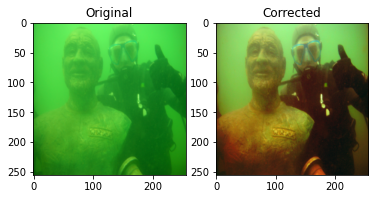

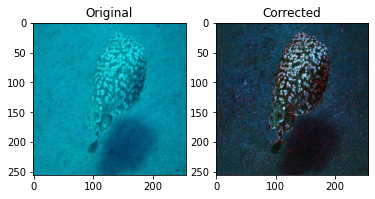

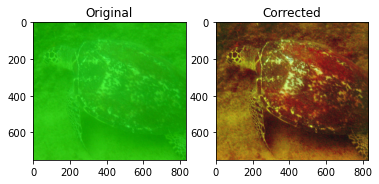

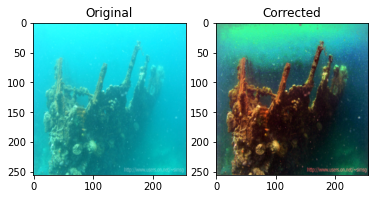

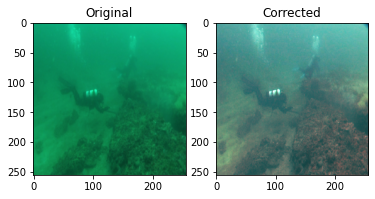

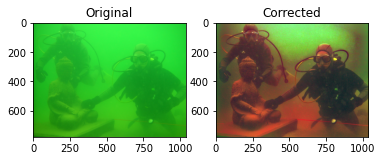

Time 0:01:41.768840


In [7]:
from IPython.display import HTML
from IPython.display import display

tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

if __name__ == '__main__':
    pass
starttime = datetime.datetime.now() #Records the time taken to run the code 

folder = (os.path.abspath("."))
path = folder + "/Datasets"
files = os.listdir(path)
files =  natsort.natsorted(files)

for i in range(len(files)):
    file = files[i]
    filepath = path + "/" + file
    prefix = file.split('.')[0]
    if os.path.isfile(filepath):
        img1 = cv2.imread(folder +'/Datasets/' + file)
        img = (img1 - img1.min()) / (img1.max() - img1.min()) * 255
        blockSize = 9
        largest_diff = determineDepth(img, blockSize)
        #print(largest_diff)
        AtomsphericLight, AtomsphericLightGB, AtomsphericLightRGB = getAtomsphericLight(largest_diff, img)
       # print('AtomsphericLightRGB',AtomsphericLightRGB)
        transmission = getTransmission(img, AtomsphericLightRGB, blockSize)
        transmission = refinedtransmission(transmission, img)

        sceneRadiance_GB = sceneRadianceGB(img, transmission, AtomsphericLightRGB)
        sceneRadiance = sceneradiance(img, sceneRadiance_GB)

        S_x = adapexpMap(img, sceneRadiance, Lambda=0.3, blockSize=blockSize)
        sceneRadiance_adap = AdaptiveSceneRadiance(sceneRadiance, S_x)

        sceneRadiance_adap = cv2.cvtColor(sceneRadiance_adap, cv2.COLOR_BGR2RGB)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 2, 1)
        plt.imshow(img1)
        plt.gca().set_title('Original')
        plt.subplot(1, 2, 2)
        plt.imshow(sceneRadiance_adap)
        plt.gca().set_title('Corrected')
        plt.show()

Endtime = datetime.datetime.now()
Time = Endtime - starttime
print('Time', Time)

## 5. Comparison to Other Methods
In order to further highleten the requirement for the three color channels to be given the treatment as discussed above for underwater images we compare the results of the Green-Blue channel dehazing, Red channel correction method with the dehazing algorithms proposed for traditionally teresstrial images.
<br>
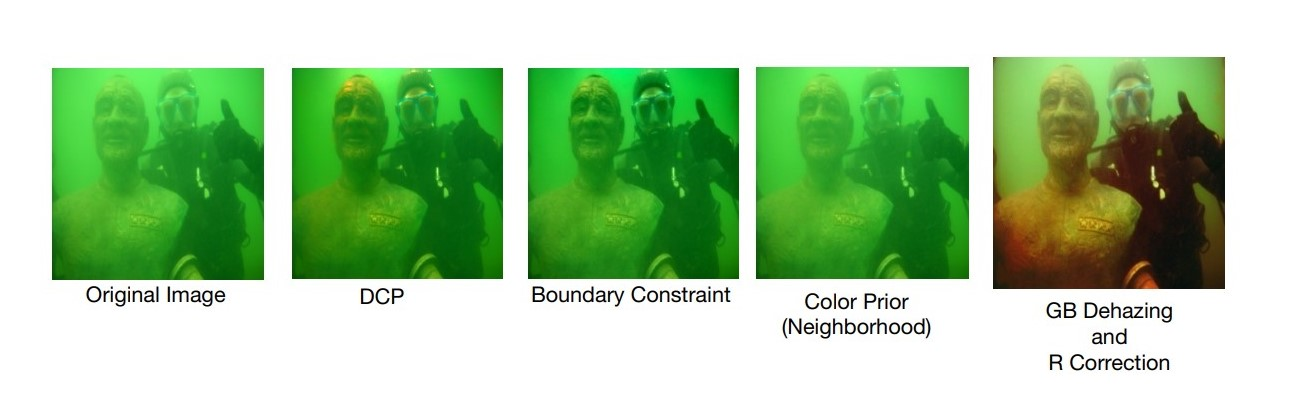

<br>
Here, we see that the traditional method of Dark Channel Prior gives poor results when it comes to de-hazing and color correcting an underwater image. This once again affirms our observation that different datasets require different methods for de-hazing and color correction. 